# 4.4 Construção do modelo SVM

- Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

- Dataset

In [2]:
df = pd.read_csv('data/proposicoes_ord_2013-2023.csv')

In [3]:
df['idProposicao'] = df['idProposicao'].astype('str')
colunas = [col for col in df.columns if col != 'VirouLei'] + ['VirouLei']
df = df.reindex(columns=colunas)

In [4]:
X = df.select_dtypes(include=['int64', 'float64'])
y = X['VirouLei']
X = X.drop(columns=['Ano','VirouLei'])

In [5]:
X

,Administração e Políticas Públicas,Desenvolvimento Social e Urbano,Direitos e Justiça,Economia e Desenvolvimento Sustentável,Infraestrutura e Gestão de Recursos,Influencia,Aliado,Oposição,PPC_igual_partidoAutor
0,0,1,0,0,0,0.077973,1,0,0
1,1,1,0,0,1,0.024691,1,0,0
2,0,1,0,0,0,0.025341,1,0,0
3,0,0,0,1,0,0.148148,1,0,0
4,0,0,0,1,0,0.033138,1,0,0
...,...,...,...,...,...,...,...,...,...
7936,1,1,0,1,0,0.080078,0,1,0
7937,0,1,0,0,0,0.029297,1,0,0
7938,0,0,1,0,0,0.132812,1,0,0
7939,1,0,0,0,0,0.007812,1,0,0


- Undersampling

In [6]:
undersample = RandomUnderSampler()
X_resampled, y_resampled = undersample.fit_resample(X, y)
X_resampled

,Administração e Políticas Públicas,Desenvolvimento Social e Urbano,Direitos e Justiça,Economia e Desenvolvimento Sustentável,Infraestrutura e Gestão de Recursos,Influencia,Aliado,Oposição,PPC_igual_partidoAutor
7006,0,1,0,0,0,0.007797,0,1,0
2318,0,1,0,0,0,0.038986,0,0,0
100,0,0,1,0,0,0.048733,0,0,0
6205,0,1,1,1,0,0.007797,1,0,0
1904,0,0,0,1,1,0.049058,1,0,0
...,...,...,...,...,...,...,...,...,...
7934,1,1,0,1,0,0.132812,1,0,1
7935,0,1,1,0,0,0.115234,1,0,0
7936,1,1,0,1,0,0.080078,0,1,0
7937,0,1,0,0,0,0.029297,1,0,0


In [7]:
RANDOM_STATE=2
BATCH_SIZE=10

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=RANDOM_STATE, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=RANDOM_STATE, test_size=0.2)


- Regularização dos parâmetros $ C\; \text{e}\; \gamma$

In [8]:
kernels = ['linear', 'rbf', 'poly']
results = {}

for kernel in kernels:
    svc = SVC(kernel=kernel, gamma='auto') 
    cv_result = cross_val_score(svc, X_resampled, y_resampled, cv=10, scoring='accuracy')
    results[kernel] = cv_result.mean() * 100

print("Acurácia média com diferentes kernels:")
for kernel, score in results.items():
    print(f"{kernel}: {score:.2f}%")


Acurácia média com diferentes kernels:
linear: 59.11%
rbf: 61.68%
poly: 56.80%


In [9]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Melhores parâmetros para o kernel RBF:", grid_search.best_params_)
print("Acurácia média:", grid_search.best_score_)


Melhores parâmetros para o kernel RBF: {'C': 0.1, 'gamma': 'scale'}
Acurácia média: 0.6054217189252711


In [10]:
svc = SVC(gamma="auto", class_weight='balanced', kernel="rbf", random_state=42)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('Acurácia no treino:', svc.score(X_train, y_train))
print('Acurácia no teste:', svc.score(X_test, y_test))

print('E_in:', 1 - svc.score(X_train, y_train))
print('E_out:', 1 - svc.score(X_test, y_test))

Acurácia no treino: 0.612603305785124
Acurácia no teste: 0.6633663366336634
E_in: 0.387396694214876
E_out: 0.3366336633663366


In [11]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Precisão:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

Precisão: 0.664547616457093
Recall: 0.6633663366336634
F1 Score: 0.6636971480166886

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.63      0.66      0.65       141
           1       0.69      0.67      0.68       162

    accuracy                           0.66       303
   macro avg       0.66      0.66      0.66       303
weighted avg       0.66      0.66      0.66       303



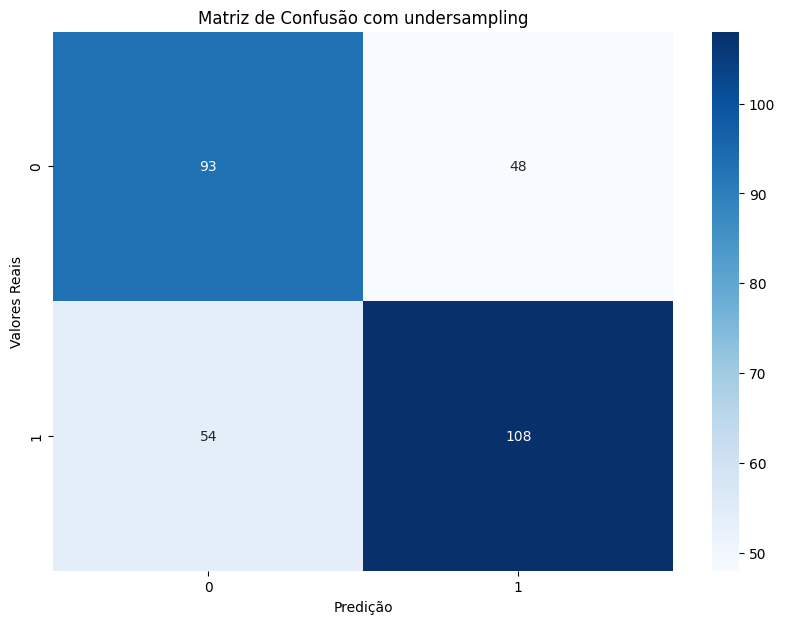

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predição')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão com undersampling')
plt.show()

Plotagem dos vetores de suporte

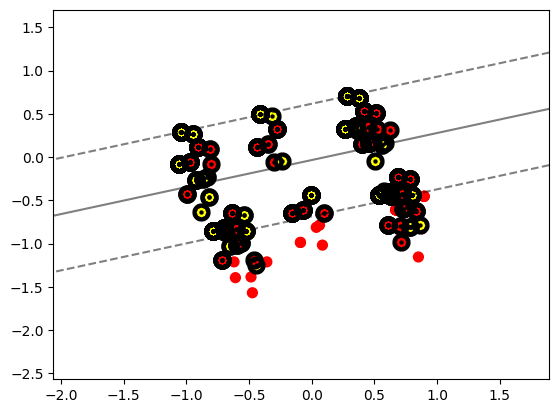

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

svc = SVC(kernel='linear')
svc.fit(X_train_pca, y_train)

def plot_svc_decision_function(model, X_train):
    xlim = (X_train[:, 0].min() - 1, X_train[:, 0].max() + 1)
    ylim = (X_train[:, 1].min() - 1, X_train[:, 1].max() + 1)
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    plt.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svc, X_train_pca)

plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=10, linewidth=10, facecolors='k')
plt.show()

In [14]:
num_support_vectors = len(svc.support_)
print(f'Número de vetores de suporte: {num_support_vectors}')

Número de vetores de suporte: 818


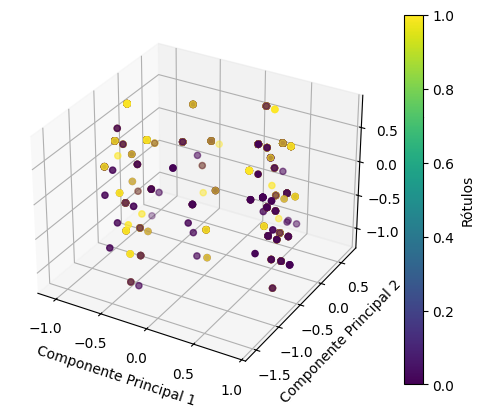

In [15]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
cbar = plt.colorbar(scatter)
cbar.set_label('Rótulos')

plt.show()

Conclusão: O modelo SVM apresenta um número elevado de vetores de suporte, o que indica que ele pode estar capturando excessivamente as variações e o "ruído" nos dados de treinamento. Esse comportamento sugere um ajuste excessivo (overfitting), onde o modelo se adapta demais aos dados, comprometendo sua capacidade de generalização. Além disso, a natureza dos dados, que parecem ser fortemente não linearmente separáveis, pode estar contribuindo para essa situação. 